<a href="https://colab.research.google.com/github/Ahmadtito17/Machine_Learning/blob/main/Jobsheet10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Nama   : Ahmad Tito N.H

NIM    : 2141720265

Kelas  : TI-3G

___________________________________________________________________________

**Jobsheet 10 - Recurrent Neural Network (RNN)**

___________________________________________________________________________

**Praktikum 1<br>**
RNN untuk Analisis Sentimen

In [1]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [2]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

Setup Input Pipelin

In [3]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [4]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


In [5]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b'In what must be one of the most blood-freezing movies ever, a transvestite is murdering people in New York, and the answer to everything may not be what people suspect. One can see how Brian DePalma takes some influence from Hitchcock with camera angles and stuff. Michael Caine plays a most thought-provoking character, while Angie Dickinson is basically a bored rich woman with a bad hairdo. Keith Gordon (who later starred in "Christine") is probably the most interesting character in the movie. But you can\'t really understand this movie without seeing it. And after seeing it, you may never know just whom you can trust. Also starring Nancy Allen and Dennis Franz.'
 b"One of Disney's best films that I can enjoy watching often. you may easily guess the outcome, but who cares? its just plain fun escape for 1 hour forty-two minutes. and after all wasn't movies meant to get away from reality for just a short time anyway? The cast sparkles with delight. -magictrain"
 b"I got to see

Buat Teks Encoder

In [6]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [7]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [8]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[  8,  49, 217, ...,   0,   0,   0],
       [ 29,   5,   1, ...,   0,   0,   0],
       [ 10, 183,   6, ...,   0,   0,   0]])

In [9]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'In what must be one of the most blood-freezing movies ever, a transvestite is murdering people in New York, and the answer to everything may not be what people suspect. One can see how Brian DePalma takes some influence from Hitchcock with camera angles and stuff. Michael Caine plays a most thought-provoking character, while Angie Dickinson is basically a bored rich woman with a bad hairdo. Keith Gordon (who later starred in "Christine") is probably the most interesting character in the movie. But you can\'t really understand this movie without seeing it. And after seeing it, you may never know just whom you can trust. Also starring Nancy Allen and Dennis Franz.'
Round-trip:  in what must be one of the most [UNK] movies ever a [UNK] is [UNK] people in new york and the [UNK] to everything may not be what people [UNK] one can see how [UNK] [UNK] takes some [UNK] from [UNK] with camera [UNK] and stuff michael [UNK] plays a most [UNK] character while [UNK] [UNK] is basically a

Buat Model

In [10]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [11]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [12]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 10s 10s/step
[0.00122371]


In [13]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 0s 64ms/step
[0.00122372]


In [14]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

Train Model

In [15]:
history = model.fit(train_dataset, epochs=10, validation_data=test_dataset, validation_steps=30)

Epoch 1/10
391/391 [==============================] - 51s 105ms/step - loss: 0.6473 - accuracy: 0.5618 - val_loss: 0.4882 - val_accuracy: 0.7641
Epoch 2/10
391/391 [==============================] - 27s 68ms/step - loss: 0.4020 - accuracy: 0.8143 - val_loss: 0.3739 - val_accuracy: 0.8458
Epoch 3/10
391/391 [==============================] - 27s 69ms/step - loss: 0.3363 - accuracy: 0.8522 - val_loss: 0.3339 - val_accuracy: 0.8589
Epoch 4/10
391/391 [==============================] - 26s 67ms/step - loss: 0.3190 - accuracy: 0.8622 - val_loss: 0.3306 - val_accuracy: 0.8422
Epoch 5/10
391/391 [==============================] - 27s 67ms/step - loss: 0.3151 - accuracy: 0.8650 - val_loss: 0.3242 - val_accuracy: 0.8594
Epoch 6/10
391/391 [==============================] - 26s 67ms/step - loss: 0.3081 - accuracy: 0.8676 - val_loss: 0.3220 - val_accuracy: 0.8526
Epoch 7/10
391/391 [==============================] - 25s 64ms/step - loss: 0.3052 - accuracy: 0.8692 - val_loss: 0.3285 - val_accuracy

In [16]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 12s 31ms/step - loss: 0.3165 - accuracy: 0.8553
Test Loss: 0.31646281480789185
Test Accuracy: 0.8552799820899963


(0.0, 0.6648297011852264)

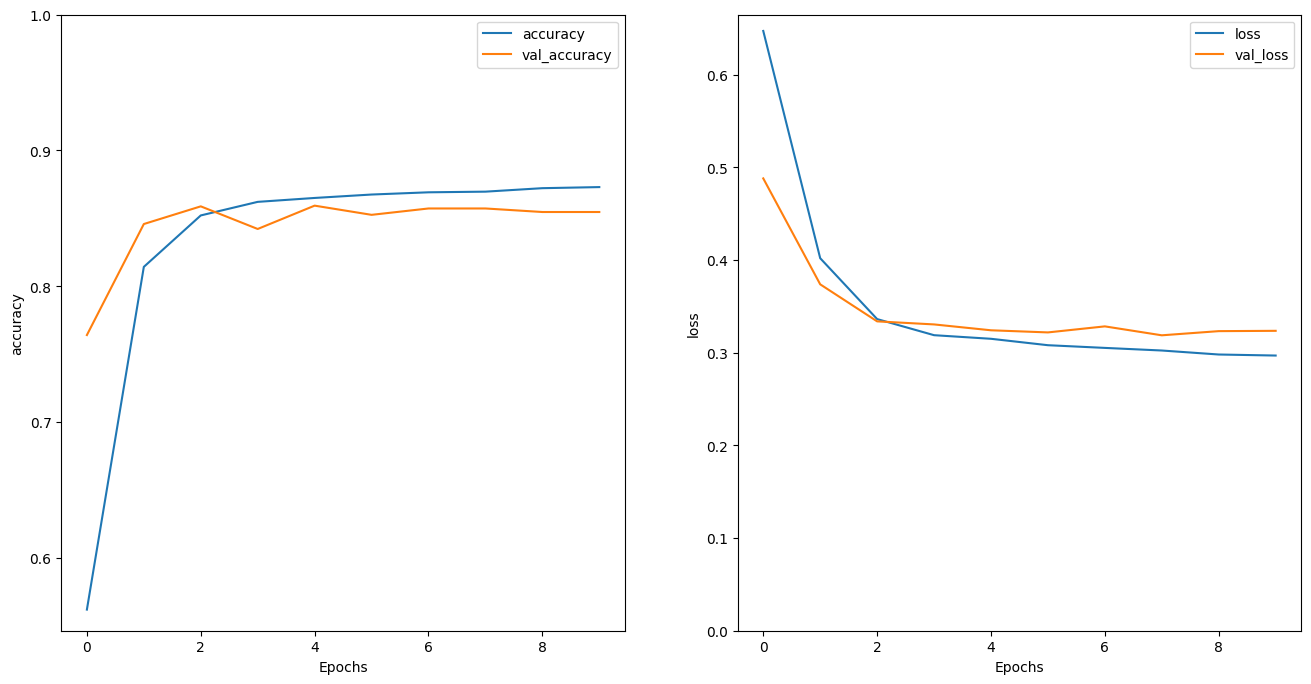

In [17]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [18]:
sample_text = ('The movie was cool. The animation and the graphics ''were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

1/1 [==============================] - 3s 3s/step


Stack Two or More LSTM Layers

In [19]:
model = tf.keras.Sequential([encoder,
  tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(1)
])

Exception ignored in: <function WeakKeyDictionary.__init__.<locals>.remove at 0x7aafb96f3010>
Traceback (most recent call last):
  File "/usr/lib/python3.10/weakref.py", line 370, in remove
    def remove(k, selfref=ref(self)):
KeyboardInterrupt: 


In [20]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
optimizer=tf.keras.optimizers.Adam(1e-4),
metrics=['accuracy'])

In [21]:
history = model.fit(train_dataset, epochs=10,
 validation_data=test_dataset,
 validation_steps=30)

Epoch 1/10
391/391 [==============================] - 79s 157ms/step - loss: 0.6259 - accuracy: 0.5962 - val_loss: 0.4579 - val_accuracy: 0.7844
Epoch 2/10
391/391 [==============================] - 47s 121ms/step - loss: 0.4088 - accuracy: 0.8194 - val_loss: 0.3655 - val_accuracy: 0.8453
Epoch 3/10
391/391 [==============================] - 47s 119ms/step - loss: 0.3558 - accuracy: 0.8466 - val_loss: 0.3523 - val_accuracy: 0.8328
Epoch 4/10
391/391 [==============================] - 47s 120ms/step - loss: 0.3376 - accuracy: 0.8547 - val_loss: 0.3537 - val_accuracy: 0.8370
Epoch 5/10
391/391 [==============================] - 49s 124ms/step - loss: 0.3290 - accuracy: 0.8612 - val_loss: 0.3380 - val_accuracy: 0.8453
Epoch 6/10
391/391 [==============================] - 47s 119ms/step - loss: 0.3197 - accuracy: 0.8649 - val_loss: 0.3335 - val_accuracy: 0.8500
Epoch 7/10
391/391 [==============================] - 46s 118ms/step - loss: 0.3157 - accuracy: 0.8675 - val_loss: 0.3498 - val_ac

In [22]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 19s 49ms/step - loss: 0.3241 - accuracy: 0.8590
Test Loss: 0.3240548074245453
Test Accuracy: 0.859000027179718


In [23]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics ''were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - 5s 5s/step
[[-1.4841785]]


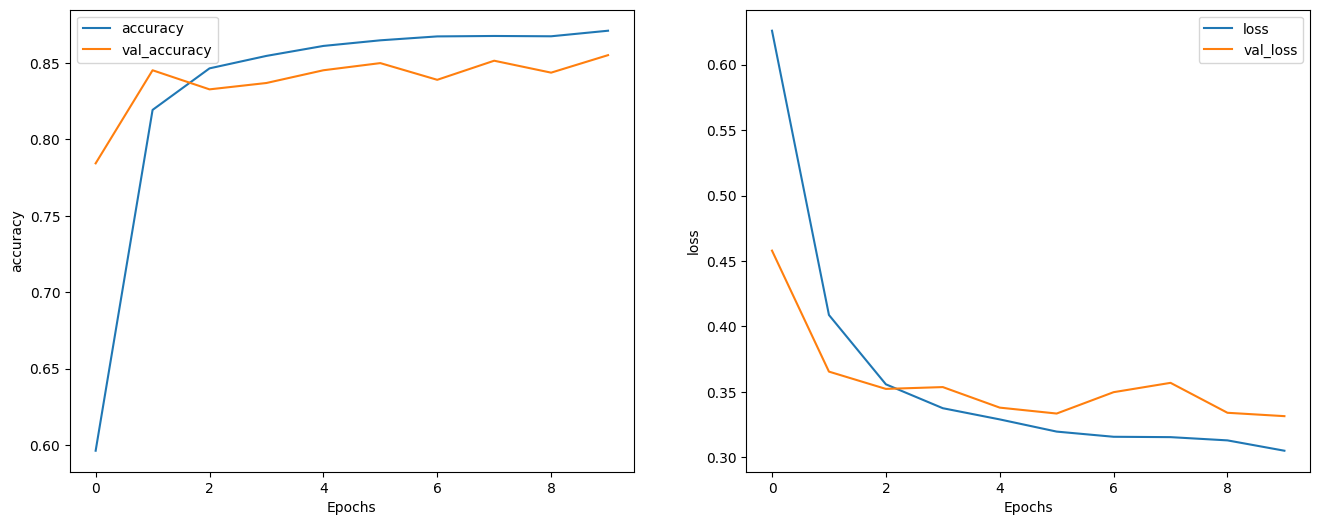

In [24]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

**Praktikum 2<br>**
Generator Teks dengan RNN

In [25]:
import tensorflow as tf
import numpy as np
import os
import time

Download Dataset Shakespeare

In [26]:
path_to_file = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')

1115394/1115394 [==============================] - 0s 0us/step


Load Data

In [27]:
# Read, then decode for py2 compat.
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
# length of text is the number of characters in it
print(f'Length of text: {len(text)} characters')

Length of text: 1115394 characters


In [28]:
# Take a look at the first 250 characters in text
print(text[:250])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.



In [29]:
# The unique characters in the file
vocab = sorted(set(text))
print(f'{len(vocab)} unique characters')

65 unique characters


Olah Teks

In [30]:
example_texts = ['abcdefg', 'xyz']
chars = tf.strings.unicode_split(example_texts, input_encoding ='UTF-8')
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

In [31]:
ids_from_chars = tf.keras.layers.StringLookup(vocabulary=list(vocab), mask_token=None)

In [32]:
ids = ids_from_chars(chars)
ids

<tf.RaggedTensor [[40, 41, 42, 43, 44, 45, 46], [63, 64, 65]]>

In [33]:
chars_from_ids = tf.keras.layers.StringLookup(
    vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)

In [34]:
chars = chars_from_ids(ids)
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

In [35]:
tf.strings.reduce_join(chars, axis=-1).numpy()

array([b'abcdefg', b'xyz'], dtype=object)

In [36]:
def text_from_ids(ids):
  return tf.strings.reduce_join(chars_from_ids(ids), axis=-1)

Prediksi

In [37]:
all_ids = ids_from_chars(tf.strings.unicode_split(text, 'UTF-8'))
all_ids

<tf.Tensor: shape=(1115394,), dtype=int64, numpy=array([19, 48, 57, ..., 46,  9,  1])>

In [38]:
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)

In [39]:
for ids in ids_dataset.take(10):
  print(chars_from_ids(ids).numpy().decode('utf-8'))

F
i
r
s
t
 
C
i
t
i


In [40]:
seq_length = 100

In [41]:
sequences = ids_dataset.batch(seq_length+1, drop_remainder=True)

for seq in sequences.take(1):
  print(chars_from_ids(seq))

tf.Tensor(
[b'F' b'i' b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':'
 b'\n' b'B' b'e' b'f' b'o' b'r' b'e' b' ' b'w' b'e' b' ' b'p' b'r' b'o'
 b'c' b'e' b'e' b'd' b' ' b'a' b'n' b'y' b' ' b'f' b'u' b'r' b't' b'h'
 b'e' b'r' b',' b' ' b'h' b'e' b'a' b'r' b' ' b'm' b'e' b' ' b's' b'p'
 b'e' b'a' b'k' b'.' b'\n' b'\n' b'A' b'l' b'l' b':' b'\n' b'S' b'p' b'e'
 b'a' b'k' b',' b' ' b's' b'p' b'e' b'a' b'k' b'.' b'\n' b'\n' b'F' b'i'
 b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':' b'\n' b'Y'
 b'o' b'u' b' '], shape=(101,), dtype=string)


In [42]:
for seq in sequences.take(5):
  print(text_from_ids(seq).numpy())

b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '
b'are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you k'
b"now Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us ki"
b"ll him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be d"
b'one: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citi'


In [43]:
def split_input_target(sequence):
  input_text = sequence[:-1]
  target_text = sequence[1:]
  return input_text, target_text

In [44]:
split_input_target(list("Tensorflow"))

(['T', 'e', 'n', 's', 'o', 'r', 'f', 'l', 'o'],
 ['e', 'n', 's', 'o', 'r', 'f', 'l', 'o', 'w'])

In [45]:
dataset = sequences.map(split_input_target)

In [46]:
for input_example, target_example in dataset.take(1):
  print("Input :", text_from_ids(input_example).numpy())
  print("Target:", text_from_ids(target_example).numpy())

Input : b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'
Target: b'irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '


Membuat Batch Training

In [47]:
# Batch size
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(64, 100), dtype=tf.int64, name=None), TensorSpec(shape=(64, 100), dtype=tf.int64, name=None))>

Buat Model

In [48]:
# Length of the vocabulary in StringLookup Layer
vocab_size = len(ids_from_chars.get_vocabulary())

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

In [49]:
class MyModel(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(rnn_units,
                                   return_sequences=True,
                                   return_state=True)
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    if states is None:
      states = self.gru.get_initial_state(x)
    x, states = self.gru(x, initial_state=states, training=training)
    x = self.dense(x, training=training)

    if return_state:
      return x, states
    else:
      return x

In [50]:
model = MyModel(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

Uji Model

In [51]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 100, 66) # (batch_size, sequence_length, vocab_size)


In [52]:
model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     multiple                  16896     
                                                                 
 gru (GRU)                   multiple                  3938304   
                                                                 
 dense_4 (Dense)             multiple                  67650     
                                                                 
Total params: 4022850 (15.35 MB)
Trainable params: 4022850 (15.35 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [53]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices, axis=-1).numpy()

In [54]:
sampled_indices

array([36, 53, 36,  4, 48, 32, 25,  8, 44, 65, 32, 65, 13, 47, 11, 61, 35,
       31, 48, 18, 54, 52, 13, 19, 39, 29, 17, 63, 46, 25, 46, 29, 58, 65,
       54, 17, 42, 22, 46, 44, 15, 52, 58, 47, 63, 22,  4, 54, 23, 11, 20,
       49, 41, 48, 10, 28, 55, 18, 49, 31, 38, 61, 63, 62, 46, 62, 40, 21,
       43,  9, 12, 64, 39, 51,  8, 22, 51, 64, 48,  8, 59, 57, 64, 12, 12,
       55, 11, 56, 17, 47, 44, 47, 21, 51, 42, 62, 38, 47, 35, 33])

In [55]:
print("Input:\n", text_from_ids(input_example_batch[0]).numpy())
print()
print("Next Char Predictions:\n", text_from_ids(sampled_indices).numpy())

Input:
 b"ate hast thou to him?\n\nShepherd:\nI know not, an't like you.\n\nClown:\nAdvocate's the court-word for a "

Next Char Predictions:
 b'WnW$iSL-ezSz?h:vVRiEom?FZPDxgLgPszoDcIgeBmshxI$oJ:Gjbi3OpEjRYvxwgwaHd.;yZl-Ilyi-try;;p:qDhehHlcwYhVT'


Train Model

In [56]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

In [57]:
example_batch_mean_loss = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("Mean loss:        ", example_batch_mean_loss)

Prediction shape:  (64, 100, 66)  # (batch_size, sequence_length, vocab_size)
Mean loss:         tf.Tensor(4.1889105, shape=(), dtype=float32)


In [58]:
tf.exp(example_batch_mean_loss).numpy()

65.9509

In [59]:
model.compile(optimizer='adam', loss=loss)

In [60]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

In [61]:
EPOCHS = 20

In [62]:
history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/20
172/172 [==============================] - 13s 55ms/step - loss: 2.7222
Epoch 2/20
172/172 [==============================] - 11s 54ms/step - loss: 1.9934
Epoch 3/20
172/172 [==============================] - 11s 55ms/step - loss: 1.7127
Epoch 4/20
172/172 [==============================] - 12s 56ms/step - loss: 1.5509
Epoch 5/20
172/172 [==============================] - 11s 56ms/step - loss: 1.4508
Epoch 6/20
172/172 [==============================] - 11s 56ms/step - loss: 1.3824
Epoch 7/20
172/172 [==============================] - 12s 57ms/step - loss: 1.3297
Epoch 8/20
172/172 [==============================] - 11s 57ms/step - loss: 1.2842
Epoch 9/20
172/172 [==============================] - 12s 58ms/step - loss: 1.2420
Epoch 10/20
172/172 [==============================] - 12s 58ms/step - loss: 1.2020
Epoch 11/20
172/172 [==============================] - 12s 58ms/step - loss: 1.1612
Epoch 12/20
172/172 [==============================] - 12s 59ms/step - loss: 1.1198
E

Generate Teks

In [63]:
class OneStep(tf.keras.Model):
  def __init__(self, model, chars_from_ids, ids_from_chars, temperature=1.0):
    super().__init__()
    self.temperature = temperature
    self.model = model
    self.chars_from_ids = chars_from_ids
    self.ids_from_chars = ids_from_chars

    # Create a mask to prevent "[UNK]" from being generated.
    skip_ids = self.ids_from_chars(['[UNK]'])[:, None]
    sparse_mask = tf.SparseTensor(
        # Put a -inf at each bad index.
        values=[-float('inf')]*len(skip_ids),
        indices=skip_ids,
        # Match the shape to the vocabulary
        dense_shape=[len(ids_from_chars.get_vocabulary())])
    self.prediction_mask = tf.sparse.to_dense(sparse_mask)

  @tf.function
  def generate_one_step(self, inputs, states=None):
    # Convert strings to token IDs.
    input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
    input_ids = self.ids_from_chars(input_chars).to_tensor()

    # Run the model.
    # predicted_logits.shape is [batch, char, next_char_logits]
    predicted_logits, states = self.model(inputs=input_ids, states=states,
                                          return_state=True)
    # Only use the last prediction.
    predicted_logits = predicted_logits[:, -1, :]
    predicted_logits = predicted_logits/self.temperature
    # Apply the prediction mask: prevent "[UNK]" from being generated.
    predicted_logits = predicted_logits + self.prediction_mask

    # Sample the output logits to generate token IDs.
    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    # Convert from token ids to characters
    predicted_chars = self.chars_from_ids(predicted_ids)

    # Return the characters and model state.
    return predicted_chars, states

In [64]:
one_step_model = OneStep(model, chars_from_ids, ids_from_chars)

In [65]:
start = time.time()
states = None
next_char = tf.constant(['ROMEO:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)
print('\nRun time:', end - start)

ROMEO:
Most royal, having so; a scrattery in this;
For I am in a traitorance to see this
Friar Juliet hath Lewis been man? Hast thou your speeches
Claudio beeasing son.

MIRANDA:
Mistress
Shall win the waves as ordering our means?
There's saddem of your households plant Fearful'd,
Because me it? come, most gracious neighbour, I warrant, honest,
According to the trath. Therefore follow me
AY, Coven'd with all this gallant:
Madam, good night: is't not of mercy!
King Henry incornem'd to put outay
Your love's fair ladies' an eager meature.

QUEEN ELIZABETH:
Thou wert not war I England for a wilded wie?

DUKE OF YORK:
Well: there's no canques forth yourself.

BUCKINGHAM:
My Lord,
I had thoughts to death and hear. You seest Kate?
Return hath tears a kingdom wretch.
And, in my state, I rest, and be not heard thee so.

DUCHESS OF YORK:
I pray you, sir, the beheld thereby thee
To this slould cheer eloved against my
Execution.

LUCIO:
Marry, so I am, boy? O both where's the matter?

CORIOLANUS:


In [66]:
start = time.time()
states = None
next_char = tf.constant(['ROMEO:', 'ROMEO:', 'ROMEO:', 'ROMEO:', 'ROMEO:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result, '\n\n' + '_'*80)
print('\nRun time:', end - start)

tf.Tensor(
[b"ROMEO:\nGood Paris, yet my fant o' the leason; buy moved to sue that you\nhow it please either than fact of the town.\n\nMayor:\nMy gracious sovereign, now thou owest that think\nyou you at all tuary.\n\nGLOUCESTER:\nThe Volsces naked, so farewell and true:\nI think so well and suitors to him and hangs to heaven!\nO, belingnorsoments, good fellows are gone, ten times,\nAnd last our soldiers unto the Tower,\nAnd some tribunes of the devices of\nhis royal point your tribunes known,\nAs now, for standing in thy looks.\nO, 'twas the leanness is so many motions\nare, for their own reports, before this dishone\nThe duke's name; and, old VAlentius;\nHere comes the thing I bid thee gaust in brist\nAn allawnary of his last.\nAnd so, he lay sweet Bianca, both hereafter,\nSince I shall crime my those that ever east where other\nBefore thy son and his owe like a lamb.\nNow, as I shall, she do see them,\nWhich not take courtesy?\n\nLEONTES:\nWell, my lord!\n\nJULIET:\nNo, none of him,

Ekspor Model Generator

In [67]:
tf.saved_model.save(one_step_model, 'one_step')
one_step_reloaded = tf.saved_model.load('one_step')

In [68]:
states = None
next_char = tf.constant(['ROMEO:'])
result = [next_char]

for n in range(100):
  next_char, states = one_step_reloaded.generate_one_step(next_char, states=states)
  result.append(next_char)

print(tf.strings.join(result)[0].numpy().decode("utf-8"))

ROMEO:
Good queen, God give your silence! is it go with this false gloutusy
Cury whil you see them here he


**Tugas Praktikum**

In [69]:
class CustomTraining(MyModel):
  @tf.function
  def train_step(self, inputs):
    inputs, labels = inputs
    with tf.GradientTape() as tape:
      predictions = self(inputs, training=True)
      loss = self.loss(labels, predictions)
      grads = tape.gradient(loss, model.trainable_variables)
      self.optimizer.apply_gradients(zip(grads, model.trainable_variables))

    return {'loss': loss}

In [70]:
model = CustomTraining(
    vocab_size=len(ids_from_chars.get_vocabulary()),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

In [71]:
model.compile(optimizer = tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))

In [72]:
model.fit(dataset, epochs=1)

172/172 [==============================] - 15s 60ms/step - loss: 2.7290


In [73]:
EPOCHS = 10

mean = tf.metrics.Mean()

for epoch in range(EPOCHS):
  start = time.time()

  mean.reset_states()
  for (batch_n, (inp, target)) in enumerate(dataset):
    logs = model.train_step([inp, target])
    mean.update_state(logs['loss'])

    if batch_n % 50 == 0:
      template = f"Epoch {epoch+1} Batch {batch_n} Loss {logs['loss']:.4f}"
      print(template)

      # saving (checkpoint) the model every 5 epochs
      if (epoch + 1) % 5 == 0:
        model.save_weights(checkpoint_prefix.format(epoch=epoch))


        print()
        print(f'Epoch {epoch+1} Loss: {mean.result().numpy():.4f}')
        print(f'Time taken for 1 epoch {time.time() - start:.2f} sec')
        print("_"*80)

model.save_weights(checkpoint_prefix.format(epoch=epoch))

Epoch 1 Batch 0 Loss 2.1990
Epoch 1 Batch 50 Loss 2.0816
Epoch 1 Batch 100 Loss 1.9526
Epoch 1 Batch 150 Loss 1.9038
Epoch 2 Batch 0 Loss 1.8260
Epoch 2 Batch 50 Loss 1.7727
Epoch 2 Batch 100 Loss 1.6516
Epoch 2 Batch 150 Loss 1.6668
Epoch 3 Batch 0 Loss 1.6273
Epoch 3 Batch 50 Loss 1.6046
Epoch 3 Batch 100 Loss 1.5375
Epoch 3 Batch 150 Loss 1.5358
Epoch 4 Batch 0 Loss 1.5112
Epoch 4 Batch 50 Loss 1.4998
Epoch 4 Batch 100 Loss 1.4360
Epoch 4 Batch 150 Loss 1.4595
Epoch 5 Batch 0 Loss 1.4198

Epoch 5 Loss: 1.4198
Time taken for 1 epoch 1.83 sec
________________________________________________________________________________
Epoch 5 Batch 50 Loss 1.4195

Epoch 5 Loss: 1.3956
Time taken for 1 epoch 4.75 sec
________________________________________________________________________________
Epoch 5 Batch 100 Loss 1.3515

Epoch 5 Loss: 1.3925
Time taken for 1 epoch 7.69 sec
________________________________________________________________________________
Epoch 5 Batch 150 Loss 1.3860

Epoch 5 L